# 第一章 数值计算技巧

In [1]:
from tqdm import tqdm
# 当我们对一个非常大的列表进行长时间计算时，估计大概需要的计算时间非常重要；
# 使用 tqdm 库，可以显示计算进程.
x_sum = 0

for i in tqdm(range(100000000)):
    x_sum += 1.0E-8

print(x_sum)

100%|██████████| 100000000/100000000 [00:08<00:00, 11868852.18it/s]

1.0000000022898672


In [1]:
from numba import jit
from tqdm import tqdm
@jit
def jit_sum():
    # 当我们对一个非常大的列表进行长时间计算时，估计大概需要的计算时间非常重要；
    # 使用 tqdm 库，可以显示计算进程.
    x_sum = 0
    for i in range(100000000):
        x_sum += 1.0E-8
    return x_sum

jit_sum()

1.0000000022898672

## 递归函数(数学中归纳法）

已知 n = 1 时结果
知道 n 到 n+1 的递推公式

例子：勒让德多项式

$P_0(x) = 1, \quad\; P_1(x) = x,\quad\; P_{n+1}(x) = \left[ (2n+1) x P_n(x) - n P_{n-1} (x)\right]/(n+1)$

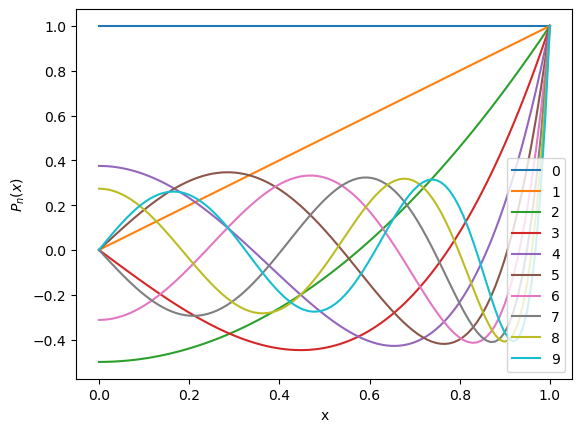

In [2]:
import numpy as np
from matplotlib import pyplot as plt
def Pn(x, n):
    '''此处,Pn是递归函数,需要调用自己计算Pn(n-1) 与 Pn(n-2)'''
    if n == 0: 
        return np.ones_like(x)
    elif n == 1: 
        return x
    else:
        return ((2*n-1)*x*Pn(x, n-1) - (n-1)*Pn(x, n-2))/n

x = np.linspace(0, 1, 100)

for n in range(10):
    legi = Pn(x, n)
    plt.plot(x, legi, label="%s"%n)
    plt.xlabel("x")
    plt.ylabel(r"$P_n(x)$")
    plt.legend(loc="best")

## 大型的计算物理程序编写原则

- 自顶向下，先规划好程序结构，将不同的功能模块化、函数化
- 每个模块可分离，并对每个模块做尽可能多的单元测试（unit tests）
- 模块、类、函数命名规范，并有清晰的说明文档 help(func)
- 对给定的物理问题，在简化假设下，对比数值解与解析解
- 检查守恒律，比如能量、动量、净电荷守恒、细致平衡等
- 如果市面上有其他代码，与其他代码结果做对比

## 截断误差、舍入误差与科学计算中的陷阱

习题 1：使用泰勒展开公式笔算 $cos(31^\circ)$，并估计截断误差。

In [3]:
import math
def cos_appro(x, delta_x):
    x=x*math.pi/180
    delta_x=delta_x*math.pi/180
    approx = math.cos(x) - math.sin(x)*delta_x
    error = -0.5*math.cos(x)*delta_x**2
    return approx, error
approx, error = cos_appro(30, 1)
print(f"approximate: {approx}, error: {error}")
print(f"accurate: {math.cos(31*math.pi/180)}, error: {math.cos(31*math.pi/180)- approx}")

approximate: 0.857298757524467, error: -0.00013190321198527908
accurate: 0.8571673007021123, error: -0.00013145682235471412


In [5]:
print("float32(pi)=", np.float32(np.pi))
print("float64(pi)=", np.float64(np.pi))

float32(pi)= 3.1415927
float64(pi)= 3.141592653589793


In [6]:
np.float32(np.pi) + np.float32(5E-8)

np.float32(3.1415927)

In [8]:
# 大数加小数困难示例：小数连加
loops = int(1E7)
res = np.float32(0.0)
dx = np.float32(1.0E-7)

for i in tqdm(range(loops)):
    res += dx

# 真实结果
ground_truth = loops*dx

print("theoretical results: %s"%(ground_truth))
print("accumulated sum:", res)
print("relative error = ", (res-ground_truth)/ground_truth)

100%|██████████| 10000000/10000000 [00:01<00:00, 8681012.27it/s]

theoretical results: 1.0
accumulated sum: 1.0647675
relative error =  0.06476748


在 c/c++ 语言中, float32 记为 float，float64 记为 double。

python 中默认 float 为 float64

numpy：np.float32 或 np.float64

一般的科学计算尽量使用 float64 （double）数据类型，会省去很多麻烦（跃过大数吃小数、相近数相减的陷阱）。

GPU （图形处理单元，简称显卡） 并行编程时，为了加快运算，一般使用 float32 而不是 double（或称 float64) 类型。

目前的人工智能（深度学习）库，有时甚至使用 float16 数据类型。

在浮点加法计算中，交换律（commutativity）成立，但结合律（associativity）不成立。也就是说， $a+b = b+a$ 但 $(a+b)+c \neq a+(b+c)$ 。因此在浮点序列加法计算中，我们可以从左到右一个个累加，也可以在原有顺序上，将他们两两分成一对。第二种算法会相对较慢并需要更多内存，也常被一些语言的特定求和函数使用，但相对结果更准确。

大数加小数困难的解决方案

为了计算速度考虑，如果不想用 double（即 float64）数据类型，又希望大量数字的求和结果比较精确， 可以考虑使用如下两种方案：

    Kahan 求和公式（解决串行求和时大数吃小数的问题）
    将串行求和转化为并行求和

In [10]:
# Kahan求和
def kahan_sum(arr):
    '''连加操作中解决大数吃小数的问题
    :arr: numpy array, 存储 float 类型
    :return: arr 中所有元素的和'''
    sum_ = np.float32(0)
    correction = np.float32(0)
    for addend in tqdm(arr):
        addend += correction                  #  <--  对新的数加入上一步的修正
        temp_sum = sum_ + addend              #     \ 开始求和
        addend_high = temp_sum - sum_         #     \ 计算实际增加的量
        correction = addend - addend_high     #   -- 计算实际增加的量和想要加入的量的差值，并将其作为下一步计算的修正。
        sum_ = temp_sum                       # update
        
    return sum_

#举例

arr = np.ones(int(1.0E6), dtype=np.float32) * 1.0E-6

sum_ = np.float32(0)
for x in tqdm(arr):
    sum_ += x 
    
print("sum(arr)=", res)

print(kahan_sum(arr))

100%|██████████| 1000000/1000000 [00:00<00:00, 6591905.15it/s]


sum(arr)= 1.0647675


100%|██████████| 1000000/1000000 [00:00<00:00, 5372966.23it/s]

1.0



避免两个相近的数相减

有时候可能会遇到两个相近数的相减，比如计算数值微分时，使用如下公式

$\frac{df}{dx}=lim_{h→0}\frac{f(x+h)−f(x)}{h}$

从微分的定义来看，h越小，df/dx的计算越精确。但h越小，f(x+h)与f(x)越接近，会出现相近数的相减问题。

举例：$f(x)=\sqrt{x}$, 此时 f(x) 对 x 的导数为，$\frac{df}{dx}=\frac{1}{2}x^{−1/2}$

在 x = 1 处，$\frac{df}{dx}=0.5$.

In [11]:
def f(x):
    #return np.sqrt(x)
    return np.sqrt(x).astype(np.float32)

def dfdx(func, x=1, h=1.0E-6):
    return (func(x+h) - func(x))/h

print("h=0.01, dfdx=", dfdx(f, h=0.01))
print("h=0.001, dfdx=", dfdx(f, h=0.001))
print("h=1.0E-6, dfdx=", dfdx(f, h=1.0E-6))
print("h=1.0E-9, dfdx=", dfdx(f, h=1.0E-9))

h=0.01, dfdx= 0.49875975
h=0.001, dfdx= 0.49984452
h=1.0E-6, dfdx= 0.47683716
h=1.0E-9, dfdx= 0.0


几个避免相近数相减的替换方案(数值分析，李红）：
$\sqrt{x+\epsilon}-\sqrt{x}=\frac{\epsilon}{\sqrt{x+\epsilon}+\sqrt{x}}$

In [12]:
def dfdx(x,h):
    return np.float32(h)/(np.sqrt(x+h).astype(np.float32)+np.sqrt(x).astype(np.float32))/np.float32(h)

print("h=0.01, dfdx=", dfdx(1, 0.01))
print("h=0.001, dfdx=", dfdx(1, 0.001))
print("h=1.0E-6, dfdx=", dfdx(1, 1.0E-6))
print("h=1.0E-9, dfdx=", dfdx(1, 1.0E-9))

h=0.01, dfdx= 0.49875617
h=0.001, dfdx= 0.4998751
h=1.0E-6, dfdx= 0.49999988
h=1.0E-9, dfdx= 0.5


$ln(x+\epsilon)-ln(x)=ln(1+\frac{\epsilon}{x})$

$for \lvert x \rvert \ll 1, e^x-1=x(1+\frac{x}{2}+\frac{x^2}{6}+\cdots)$

$for \lvert x \rvert \ll 1, 1-cos(x)=2sin^2\frac{x}{2}$

避免两个浮点数的相等（==）比较

因为计算机上浮点数有舍入误差，对浮点数做 == 比较有时会出现不可预测的错误。

举例：

a = 3.14159268

b = 3.14159269

判断 a==b 返回 True 还是 False?

对于 float32 类型，最后的 8 和 9在舍入误差上，我们希望它返回 True

In [13]:
import numpy as np
# 默认使用 float64 类型
a = 3.14159268
b = 3.14159269
print(f"{a==b}")
# 比较好的做法是 np.isclose() 或 np.allclose() 函数
# 尤其是在对比数值解与解析解时
np.isclose(a, b)

# 使用 np.isclose(SHIFT + TAB), 在函数括弧处按 SHIFT+TAB 键看函数介绍
# 或 help(np.isclose)

False


np.True_

In [14]:
help(np.isclose)

Help on _ArrayFunctionDispatcher in module numpy:

isclose(a, b, rtol=1e-05, atol=1e-08, equal_nan=False)
    Returns a boolean array where two arrays are element-wise equal within a
    tolerance.

    The tolerance values are positive, typically very small numbers.  The
    relative difference (`rtol` * abs(`b`)) and the absolute difference
    `atol` are added together to compare against the absolute difference
    between `a` and `b`.

    .. warning:: The default `atol` is not appropriate for comparing numbers
                 with magnitudes much smaller than one (see Notes).

    Parameters
    ----------
    a, b : array_like
        Input arrays to compare.
    rtol : array_like
        The relative tolerance parameter (see Notes).
    atol : array_like
        The absolute tolerance parameter (see Notes).
    equal_nan : bool
        Whether to compare NaN's as equal.  If True, NaN's in `a` will be
        considered equal to NaN's in `b` in the output array.

    Returns
   

NaN （Not A Number) 和 inf ($\inf$)

自己辛苦编写了一长串程序，结果却输出 nan，怎么办？注意下面这些情形：

$\frac{1}{x}, \ x = 0$

$x=\sqrt{x}, \ x < 0$

$log(x), \ x < 0$

$e^x, \ large \ x$

In [15]:
import numpy as np
x = np.sin(3/2 * np.pi)
# 根号下出现了负值
y = np.sqrt(x)
print(f"{np.sin(y)}")
print("x =", x)
# 负数开 4 次方，或其他偶数次方
print(f"{x**(1/4)}")
x = np.sin(0)
print(f"{100/x}")

nan
x = -1.0
nan
inf


/tmp/ipykernel_48700/1619405308.py:4: RuntimeWarning: invalid value encountered in sqrt
  y = np.sqrt(x)
/tmp/ipykernel_48700/1619405308.py:8: RuntimeWarning: invalid value encountered in scalar power
  print(f"{x**(1/4)}")
/tmp/ipykernel_48700/1619405308.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"{100/x}")


In [16]:
import numpy as np
# 根据粒子出射动量 (px, py)，计算方位角
def phi(px, py):
    '''计算出射角度
    :px: 动量的 x 分量
    :py: 动量的 y 分量
    :return: 方位角 [-pi, pi)'''
    return np.arctan2(py, px)/np.pi
    # 注意：不能使用 np.arctan(py/px) 函数
    # 因为，如果粒子沿 y 轴出射, px==0, 
    # py/px 会出现“除零错误”
    # 而numpy提供的arctan2函数可以规避这一点，
    # arctan2 会考虑 px 和 py 的符号，判断点在哪个象限。
    # 返回的角度范围覆盖完整的圆，
    # 而arctan(py / px) 只能区分上下两个象限。

print(f"phi(px=1, py=1) = {phi(1, 1)} pi")
print(f"phi(px=-1, py=1) = {phi(-1, 1)} pi")
print(f"phi(px=1, py=-1) = {phi(1, -1)} pi")
print(f"phi(px=0, py=1) = {phi(0, 1)} pi")

def phi_wrong(px, py):
    '''这是错误的计算粒子出射方位角方法'''
    return np.arctan(py/px)

phi_wrong(px=0, py=1)

phi(px=1, py=1) = 0.25 pi
phi(px=-1, py=1) = 0.75 pi
phi(px=1, py=-1) = -0.25 pi
phi(px=0, py=1) = 0.5 pi


ZeroDivisionError: division by zero

In [17]:
import numpy as np
# 处理办法: 
# (1) 加 assert 在 x < 0 时直接报错，不继续进行计算
# assert 是 Python 中的断言语句，用于在程序运行时做出假设性检查，其作用是：
# 当你希望某个条件为真（True）时，可以使用 assert。如果条件为假（False），
# 程序会抛出 AssertionError 异常，终止执行，并可附加错误信息。
x = -1 
assert x > 0, "x < 0"
np.sqrt(x)

AssertionError: x < 0

In [18]:
import warnings
import numpy as np
# (2) 异常捕获机制
x = -1
with warnings.catch_warnings():
    warnings.simplefilter("error", RuntimeWarning)  # 将警告当作异常处理
    try:
        np.sqrt(x)
    except RuntimeWarning:
        raise ValueError("不能对负数开平方")

ValueError: 不能对负数开平方

预估任务复杂度，内存与硬盘占用

有时候写了一个程序，结果运行起来永不停歇，或者爆出内存不够、显存不够或磁盘空间不够。

为了预防这些问题，要对任务复杂度、内存和硬盘占用进行预估。

举例：N 个带电粒子的分子动力学模拟，每一步需要计算每一对粒子之间的库伦相互作用，有$∼O(N^2)$
次操作.
对于 1 GHZ 的电脑CPU，每秒浮点数操作次数为$10^9$，假设遍历一次需要$10^{−9}$秒，可以估算每一步花费时间，$N^2×10^{−9}$ s

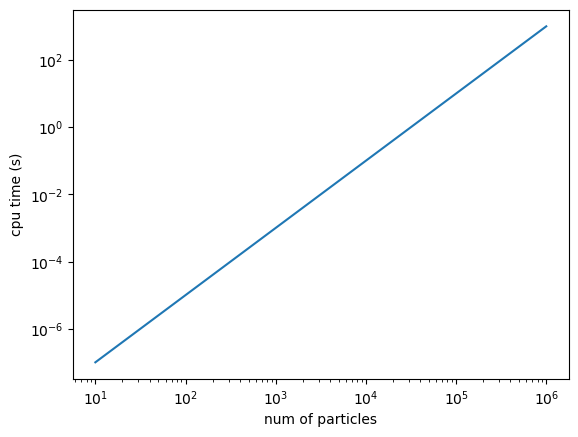

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def plot_time(dt = 1.0E-9):
    N = np.logspace(1, 6)
    t = N**2 * dt
    plt.loglog(N, t)
    plt.xlabel("num of particles")
    plt.ylabel("cpu time (s)")

plot_time()

**时间复杂度**和**空间复杂度**是衡量一个算法效率的重要标准。
我们衡量一个算法的效率时，最重要的不是看它在某个数据规模下的用时，而是看它的用时随数据规模而增长的趋势，即**时间复杂度**。

内存、显存与硬盘占用

举例：假设电脑的可用内存为 1 GB，做三维相对论流体力学计算需要将空间离散化为$N_x \times N_y \times N_z = 1000 \times 1000 \times 1000$ grids

问：如果使用 float32 类型数据，内存是否够用？

1 G = $10^9$, 1 M(兆) = $10^6$, 1 Byte(字节)= 8 bits(位)

1 float32 = 4 Byte

1 float64(double) = 8 Byte

假设每个格子上只保存一个浮点数，

$\times N_z = 1000 \times 1000 \times 1000$ 个格子上的 float32 类型浮点数占用内存为 4 GB, 显然内存不够用。

如果设 $N_x = 300,N_y = 300,N_z = 300$,

则内存占用为 108 兆比特，明显够用。

$27 M float32 \times 4 B/float32=108 MB$

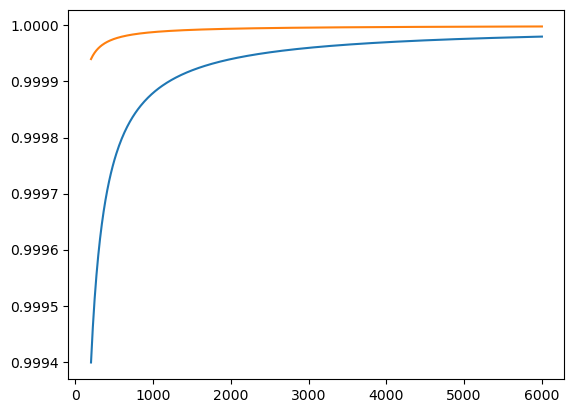

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants as C

def plot_exp() -> None:
    T = np.linspace(200, 6000, 500)
    p1 = np.exp(-1 / C.gas_constant / T)
    p2 = np.exp(-0.1 / C.gas_constant / T)
    plt.plot(T, p1)
    plt.plot(T, p2)
plot_exp()

## 最小二乘法